![image info](https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/images/banner_1.png)

# Proyecto 1 - Predicción de precios de vehículos usados

En este proyecto podrán poner en práctica sus conocimientos sobre modelos predictivos basados en árboles y ensambles, y sobre la disponibilización de modelos. Para su desasrrollo tengan en cuenta las instrucciones dadas en la "Guía del proyecto 1: Predicción de precios de vehículos usados".

**Entrega**: La entrega del proyecto deberán realizarla durante la semana 4. Sin embargo, es importante que avancen en la semana 3 en el modelado del problema y en parte del informe, tal y como se les indicó en la guía.

Para hacer la entrega, deberán adjuntar el informe autocontenido en PDF a la actividad de entrega del proyecto que encontrarán en la semana 4, y subir el archivo de predicciones a la [competencia de Kaggle](https://www.kaggle.com/t/b8be43cf89c540bfaf3831f2c8506614).

## Datos para la predicción de precios de vehículos usados

En este proyecto se usará el conjunto de datos de Car Listings de Kaggle, donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como: año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
# Importación librerías
import pandas as pd
import numpy as np

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from math import sqrt

## Preprocesamiento de datos

In [3]:
# Carga de datos de archivo .csv
dataTraining = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/dataTrain_carListings.zip')
dataTesting = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/dataTest_carListings.zip', index_col=0)

In [82]:
# Visualización datos de entrenamiento
dataTraining.head()

,Price,Year,Mileage,State,Make,Model
0,34995,2017,9913,FL,Jeep,Wrangler
1,37895,2015,20578,OH,Chevrolet,Tahoe4WD
2,18430,2012,83716,TX,BMW,X5AWD
3,24681,2014,28729,OH,Cadillac,SRXLuxury
4,26998,2013,64032,CO,Jeep,Wrangler


In [83]:
# Visualización datos de test
dataTesting.head()

,Year,Mileage,State,Make,Model
ID,,,,,
0,2014,31909,MD,Nissan,MuranoAWD
1,2017,5362,FL,Jeep,Wrangler
2,2014,50300,OH,Ford,FlexLimited
3,2004,132160,WA,BMW,5
4,2015,25226,MA,Jeep,Grand


In [78]:
# Predicción del conjunto de test - acá se genera un número aleatorio como ejemplo
np.random.seed(42)
y_pred = pd.DataFrame(np.random.rand(dataTesting.shape[0]) * 75000 + 5000, index=dataTesting.index, columns=['Price'])

In [108]:
# Guardar predicciones en formato exigido en la competencia de kaggle
y_pred.to_csv('test_submission.csv', index_label='ID')
y_pred.head()

,Price
ID,
0,33090.508914
1,76303.572981
2,59899.545636
3,49899.386315
4,16701.398033


In [35]:
# Eliminación filas con observaciones nulas
dataTraining = dataTraining.dropna()

In [36]:
print('Numero de regitros:  '+str(len(dataTraining)))
print('Numero de Variables:  '+str(dataTraining.shape[1] ))
#Numero de datos faltantes
print('Numero de datos faltantes por Variable:')
dataTraining.isnull().sum()

Numero de regitros:  400000
Numero de Variables:  6
Numero de datos faltantes por Variable:


Price      0
Year       0
Mileage    0
State      0
Make       0
Model      0
dtype: int64

In [37]:
print('Numero de regitros:  '+str(len(dataTesting)))
print('Numero de Variables:  '+str(dataTesting.shape[1] ))
#Numero de datos faltantes
print('Numero de datos faltantes por Variable:')
dataTesting.isnull().sum()

Numero de regitros:  100000
Numero de Variables:  5
Numero de datos faltantes por Variable:


Year       0
Mileage    0
State      0
Make       0
Model      0
dtype: int64

In [4]:
dataTraining = pd.get_dummies(dataTraining, columns=['State'])
dataTraining = pd.get_dummies(dataTraining, columns=['Make'])
dataTraining = pd.get_dummies(dataTraining, columns=['Model'])

In [43]:
dataTraining

,Price,Year,Mileage,State_ AK,State_ AL,State_ AR,State_ AZ,State_ CA,State_ CO,State_ CT,...,Model_Yaris4dr,Model_YarisBase,Model_YarisLE,Model_Yukon,Model_Yukon2WD,Model_Yukon4WD,Model_Yukon4dr,Model_tC2dr,Model_xB5dr,Model_xD5dr
0,34995,2017,9913,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,37895,2015,20578,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,18430,2012,83716,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,24681,2014,28729,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,26998,2013,64032,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,29900,2015,25287,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
399996,17688,2015,17677,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
399997,24907,2014,66688,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
399998,11498,2014,37872,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
dataTesting = pd.get_dummies(dataTesting, columns=['State'])
dataTesting = pd.get_dummies(dataTesting, columns=['Make'])
dataTesting = pd.get_dummies(dataTesting, columns=['Model'])

In [45]:
dataTesting

,Year,Mileage,State_ AK,State_ AL,State_ AR,State_ AZ,State_ CA,State_ CO,State_ CT,State_ DC,...,Model_Yaris4dr,Model_YarisBase,Model_YarisLE,Model_Yukon,Model_Yukon2WD,Model_Yukon4WD,Model_Yukon4dr,Model_tC2dr,Model_xB5dr,Model_xD5dr
ID,,,,,,,,,,,,,,,,,,,,,
0,2014,31909,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2017,5362,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2014,50300,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2004,132160,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2015,25226,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2015,82719,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99996,2015,19711,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99997,2016,48049,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# Supongamos que el primer dataframe se llama df1 y el segundo df2
# Primero, encontramos las dos columnas diferentes y las eliminamos de uno de los dataframes
diff_cols = set(dataTraining.columns).difference(set(dataTesting.columns))
#df1 = df1.drop(diff_cols, axis=1)

# Luego, comprobamos si ambos dataframes tienen las mismas columnas
if dataTraining.columns.equals(dataTesting.columns):
    print("Ambos dataframes tienen las mismas columnas.")
else:
    print("Los dataframes tienen columnas diferentes.")


Los dataframes tienen columnas diferentes.


In [7]:
diff_cols

{'Make_Freightliner', 'Price'}

In [8]:
dataTraining = dataTraining.drop(['Make_Freightliner'], axis=1)

In [85]:
# Separación de variables predictoras (X) y variable de interés (y)
y = dataTraining['Price']
X = dataTraining.drop(['Price'], axis=1)

In [216]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Calibración del modelo

### XGBoost

In [65]:
#MODELO XGBOOST
clf = XGBRegressor()
print(clf)
# Entrenamiento (fit) y desempeño del modelo XGBoost
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(f"El MSE del modelo es: {mean_squared_error(y_test, y_pred)}")
print(f"El R2 del modelo es: {r2_score(y_test, y_pred)}")

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)
El MSE del modelo es: 21882789.048640464
El R2 del modelo es: 0.8112673368178874


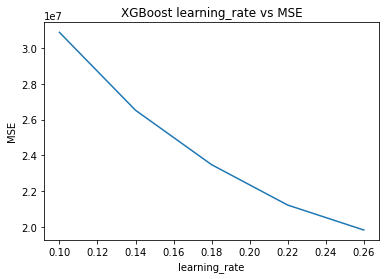

El mejor valor de learning_rate es: 0.26
MSE en conjunto de prueba con mejor valor de learning_rate:  19818080.280611884
R2 en conjunto de prueba con mejor valor de learning_rate:  0.827742686712283


In [83]:
#Calibración para learning rate

# Definir los diferentes valores de learning_rate que se van a probar
#learning_rate = np.arange(0.01, 0.3, 0.01)
learning_rate = np.arange(0.1, 0.3, 0.04)
# Inicializar la lista donde se guardarán los resultados
medias = []
# Entrenar el modelo para cada valor de learning_rate y calcular el MSE
for i in learning_rate:
    clf = XGBRegressor(learning_rate=i)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    medias.append(mean_squared_error(y_test, y_pred))
# Graficar los resultados
plt.plot(learning_rate, medias)
plt.title("XGBoost learning_rate vs MSE")
plt.xlabel('learning_rate')
plt.ylabel('MSE')
plt.show()
# Seleccionar el mejor valor de learning_rate
best_learning_rate = learning_rate[np.argmin(medias)]
print("El mejor valor de learning_rate es:", best_learning_rate)
# Entrenar un nuevo modelo XGBoost con el mejor valor de learning_rate encontrado
clf = XGBRegressor(learning_rate=best_learning_rate)
clf.fit(X_train, y_train)
# Realizar predicciones en el conjunto de prueba
y_pred = clf.predict(X_test)
# Evaluar el rendimiento del modelo utilizando la métrica MSE
mse_lr = mean_squared_error(y_test, y_pred)
r2_lr = r2_score(y_test, y_pred)
print("MSE en conjunto de prueba con mejor valor de learning_rate: ", mse_lr)
print("R2 en conjunto de prueba con mejor valor de learning_rate: ", r2_lr)

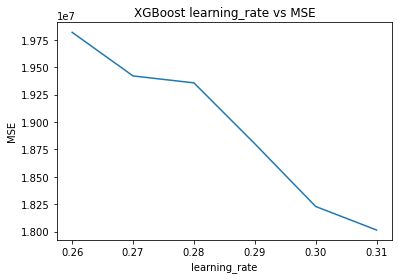

El mejor valor de learning_rate es: 0.31000000000000005
MSE en conjunto de prueba con mejor valor de learning_rate:  18015297.561663147
R2 en conjunto de prueba con mejor valor de learning_rate:  0.8434123430670127


In [86]:
#Calibración para learning rate

# Definir los diferentes valores de learning_rate que se van a probar
#learning_rate = np.arange(0.01, 0.3, 0.01)
learning_rate = np.arange(0.26, 0.32, 0.01)
# Inicializar la lista donde se guardarán los resultados
medias = []
# Entrenar el modelo para cada valor de learning_rate y calcular el MSE
for i in learning_rate:
    clf = XGBRegressor(learning_rate=i)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    medias.append(mean_squared_error(y_test, y_pred))
# Graficar los resultados
plt.plot(learning_rate, medias)
plt.title("XGBoost learning_rate vs MSE")
plt.xlabel('learning_rate')
plt.ylabel('MSE')
plt.show()
# Seleccionar el mejor valor de learning_rate
best_learning_rate = learning_rate[np.argmin(medias)]
print("El mejor valor de learning_rate es:", best_learning_rate)
# Entrenar un nuevo modelo XGBoost con el mejor valor de learning_rate encontrado
clf = XGBRegressor(learning_rate=best_learning_rate)
clf.fit(X_train, y_train)
# Realizar predicciones en el conjunto de prueba
y_pred = clf.predict(X_test)
# Evaluar el rendimiento del modelo utilizando la métrica MSE
mse_lr = mean_squared_error(y_test, y_pred)
r2_lr = r2_score(y_test, y_pred)
print("MSE en conjunto de prueba con mejor valor de learning_rate: ", mse_lr)
print("R2 en conjunto de prueba con mejor valor de learning_rate: ", r2_lr)

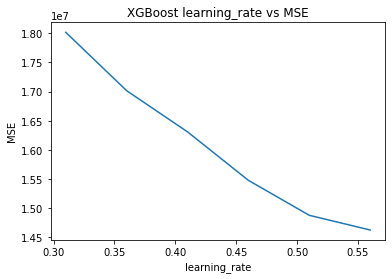

El mejor valor de learning_rate es: 0.5599999999999999
MSE en conjunto de prueba con mejor valor de learning_rate:  14628240.66367844
R2 en conjunto de prueba con mejor valor de learning_rate:  0.8728523954302208


In [89]:
#Calibración para learning rate

# Definir los diferentes valores de learning_rate que se van a probar
#learning_rate = np.arange(0.01, 0.3, 0.01)
learning_rate = np.arange(0.31, 0.6, 0.05)
# Inicializar la lista donde se guardarán los resultados
medias = []
# Entrenar el modelo para cada valor de learning_rate y calcular el MSE
for i in learning_rate:
    clf = XGBRegressor(learning_rate=i)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    medias.append(mean_squared_error(y_test, y_pred))
# Graficar los resultados
plt.plot(learning_rate, medias)
plt.title("XGBoost learning_rate vs MSE")
plt.xlabel('learning_rate')
plt.ylabel('MSE')
plt.show()
# Seleccionar el mejor valor de learning_rate
best_learning_rate = learning_rate[np.argmin(medias)]
print("El mejor valor de learning_rate es:", best_learning_rate)
# Entrenar un nuevo modelo XGBoost con el mejor valor de learning_rate encontrado
clf = XGBRegressor(learning_rate=best_learning_rate)
clf.fit(X_train, y_train)
# Realizar predicciones en el conjunto de prueba
y_pred = clf.predict(X_test)
# Evaluar el rendimiento del modelo utilizando la métrica MSE
mse_lr = mean_squared_error(y_test, y_pred)
r2_lr = r2_score(y_test, y_pred)
print("MSE en conjunto de prueba con mejor valor de learning_rate: ", mse_lr)
print("R2 en conjunto de prueba con mejor valor de learning_rate: ", r2_lr)

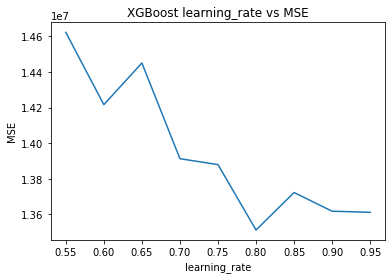

El mejor valor de learning_rate es: 0.8000000000000003
MSE en conjunto de prueba con mejor valor de learning_rate:  13512782.44663595
R2 en conjunto de prueba con mejor valor de learning_rate:  0.8825478771737488


In [124]:
#Calibración para learning rate

# Definir los diferentes valores de learning_rate que se van a probar
#learning_rate = np.arange(0.01, 0.3, 0.01)
learning_rate = np.arange(0.55, 1.0, 0.05)
# Inicializar la lista donde se guardarán los resultados
medias = []
# Entrenar el modelo para cada valor de learning_rate y calcular el MSE
for i in learning_rate:
    clf = XGBRegressor(learning_rate=i)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    medias.append(mean_squared_error(y_test, y_pred))
# Graficar los resultados
plt.plot(learning_rate, medias)
plt.title("XGBoost learning_rate vs MSE")
plt.xlabel('learning_rate')
plt.ylabel('MSE')
plt.show()
# Seleccionar el mejor valor de learning_rate
best_learning_rate = learning_rate[np.argmin(medias)]
print("El mejor valor de learning_rate es:", best_learning_rate)
# Entrenar un nuevo modelo XGBoost con el mejor valor de learning_rate encontrado
clf = XGBRegressor(learning_rate=best_learning_rate)
clf.fit(X_train, y_train)
# Realizar predicciones en el conjunto de prueba
y_pred = clf.predict(X_test)
# Evaluar el rendimiento del modelo utilizando la métrica MSE
mse_lr = mean_squared_error(y_test, y_pred)
r2_lr = r2_score(y_test, y_pred)
print("MSE en conjunto de prueba con mejor valor de learning_rate: ", mse_lr)
print("R2 en conjunto de prueba con mejor valor de learning_rate: ", r2_lr)

El mejor valor de gamma es: 0.1


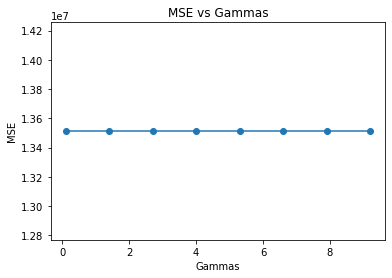

MSE en conjunto de prueba con mejor valor de learning_rate y el mejor gamma es:  13512782.44663595
R2 en conjunto de prueba con mejor valor de learning_rate y el mejor gamma es:  0.8825478771737488


In [129]:
#Calibración del mejor gamma

# Definir los diferentes valores de gamma que se van a probar
#gammas = np.arange(0.1, 10, 0.5)
gammas = np.arange(0.1, 10, 1.3)
# Entrenar modelos XGBoost con cada valor de gamma y calcular el MSE en el conjunto de prueba
mses = []
for gamma in gammas:
    clf = XGBRegressor(gamma=gamma,learning_rate=best_learning_rate)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mses.append(mse)
# Encontrar el índice del valor de gamma con el MSE más bajo
best_gamma_idx = np.argmin(mses)
best_gamma = gammas[best_gamma_idx]
# Imprimir el valor de gamma con el MSE más bajo
print("El mejor valor de gamma es:", best_gamma)
# Graficar los resultados
plt.plot(gammas, mses, '-o')
plt.xlabel('Gammas')
plt.ylabel('MSE')
plt.title('MSE vs Gammas')
plt.show()
# Entrenar un nuevo modelo XGBoost con el mejor valor de learning_rate encontrado y el mejor gamma
clf = XGBRegressor(learning_rate=best_learning_rate, gamma = best_gamma)
clf.fit(X_train, y_train)
# Realizar predicciones en el conjunto de prueba
y_pred = clf.predict(X_test)
# Evaluar el rendimiento del modelo utilizando la métrica MSE
mse_g = mean_squared_error(y_test, y_pred)
print("MSE en conjunto de prueba con mejor valor de learning_rate y el mejor gamma es: ", mse_g)  
r2_g = r2_score(y_test, y_pred)
print("R2 en conjunto de prueba con mejor valor de learning_rate y el mejor gamma es: ", r2_g)

El mejor valor de colsample_bytree es: 0.9


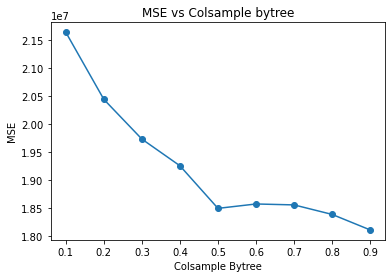

MSE en conjunto de prueba con mejor valor de learning_rate, el mejor gamma, y el mejor colsample_bytree es:  13659672.291647239
R2 en conjunto de prueba con mejor valor de learning_rate, el mejor gamma, y el mejor colsample_bytree es:  0.8812711213178526


In [132]:
#Calibración del mejor colsample_bytree

# Definir los diferentes valores de colsample_bytree que se van a probar
#colsamples = np.arange(0.1, 1, 0.01)
colsamples = np.arange(0.1, 1, 0.1)
# Entrenar modelos XGBoost con cada valor de colsample_bytree y calcular el MSE en el conjunto de prueba
mses = []
for colsample in colsamples:
    clf = XGBRegressor(colsample_bytree=colsample)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mses.append(mse)
# Encontrar el índice del valor de colsample_bytree con el MSE más bajo
best_colsample_idx = np.argmin(mses)
best_colsample = colsamples[best_colsample_idx]
# Imprimir el valor de colsample_bytree con el MSE más bajo
print("El mejor valor de colsample_bytree es:", best_colsample)
# Graficar los resultados
plt.plot(colsamples, mses, '-o')
#plt.xscale('log')
plt.xlabel('Colsample Bytree')
plt.ylabel('MSE')
plt.title('MSE vs Colsample bytree')
plt.show()
# Entrenar un nuevo modelo XGBoost con el mejor valor de learning_rate encontrado y el mejor gamma
clf = XGBRegressor(learning_rate=best_learning_rate, gamma = best_gamma, colsample_bytree = best_colsample)
clf.fit(X_train, y_train)
# Realizar predicciones en el conjunto de prueba
y_pred = clf.predict(X_test)
# Evaluar el rendimiento del modelo utilizando la métrica MSE
mse_CST = mean_squared_error(y_test, y_pred)
r2_CST = r2_score(y_test, y_pred)
print("MSE en conjunto de prueba con mejor valor de learning_rate, el mejor gamma, y el mejor colsample_bytree es: ", mse_CST)
print("R2 en conjunto de prueba con mejor valor de learning_rate, el mejor gamma, y el mejor colsample_bytree es: ", r2_CST)

El mejor valor de colsample_bytree es: 0.9500000000000001


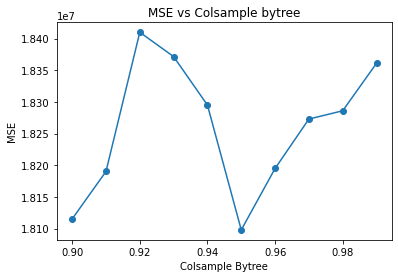

MSE en conjunto de prueba con mejor valor de learning_rate, el mejor gamma, y el mejor colsample_bytree es:  13597017.968465246
R2 en conjunto de prueba con mejor valor de learning_rate, el mejor gamma, y el mejor colsample_bytree es:  0.8818157081408129


In [138]:
#Calibración del mejor colsample_bytree

# Definir los diferentes valores de colsample_bytree que se van a probar
#colsamples = np.arange(0.1, 1, 0.01)
colsamples = np.arange(0.9, 1.0, 0.01)
# Entrenar modelos XGBoost con cada valor de colsample_bytree y calcular el MSE en el conjunto de prueba
mses = []
for colsample in colsamples:
    clf = XGBRegressor(colsample_bytree=colsample)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mses.append(mse)
# Encontrar el índice del valor de colsample_bytree con el MSE más bajo
best_colsample_idx = np.argmin(mses)
best_colsample = colsamples[best_colsample_idx]
# Imprimir el valor de colsample_bytree con el MSE más bajo
print("El mejor valor de colsample_bytree es:", best_colsample)
# Graficar los resultados
plt.plot(colsamples, mses, '-o')
#plt.xscale('log')
plt.xlabel('Colsample Bytree')
plt.ylabel('MSE')
plt.title('MSE vs Colsample bytree')
plt.show()
# Entrenar un nuevo modelo XGBoost con el mejor valor de learning_rate encontrado y el mejor gamma
clf = XGBRegressor(learning_rate=best_learning_rate, gamma = best_gamma, colsample_bytree = best_colsample)
clf.fit(X_train, y_train)
# Realizar predicciones en el conjunto de prueba
y_pred = clf.predict(X_test)
# Evaluar el rendimiento del modelo utilizando la métrica MSE
mse_CST = mean_squared_error(y_test, y_pred)
r2_CST = r2_score(y_test, y_pred)
print("MSE en conjunto de prueba con mejor valor de learning_rate, el mejor gamma, y el mejor colsample_bytree es: ", mse_CST)
print("R2 en conjunto de prueba con mejor valor de learning_rate, el mejor gamma, y el mejor colsample_bytree es: ", r2_CST)

### Random Forest

In [178]:
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
#Se entrena el modelo random forest
clfRF = RandomForestRegressor(random_state=0)
clfRF.fit(X_train, y_train)
#Luego se hacen predicciones sobre la muestra
prediccionRF=clfRF.predict(X_test)
mse = mean_squared_error(y_test, prediccionRF)
print(f"El MSE del modelo es: {mse}")
#print(f"El R2 del modelo es: {r2_score(y_test, prediccionRF)}")

#X_train, X_test, y_train, y_test

El MSE del modelo es: 25764040.64700009


El mejor valor de n_estimators es: 290
MSE en conjunto de prueba con mejor valor de n_estimators:  25695643.27155149
r2 en conjunto de prueba con mejor valor de n_estimators:  0.7783825829496474


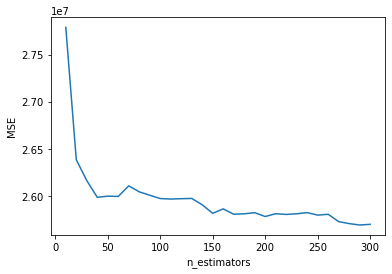

In [180]:

#calibración de n estimators

# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
estimator_range = range(10, 310, 10)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
mse_scores = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    rfr = RandomForestRegressor(n_estimators=estimator, random_state=1, n_jobs=-1)
    rfr.fit(X_train, y_train)
    y_pred = rfr.predict(X_test)
    mse_scores.append(mean_squared_error(y_test, y_pred))

# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(estimator_range, mse_scores)
plt.xlabel('n_estimators')
plt.ylabel('MSE')

# Seleccionar el mejor valor de n_estimators
best_n_estimators = estimator_range[np.argmin(mse_scores)]
print("El mejor valor de n_estimators es:", best_n_estimators)


rfr = RandomForestRegressor(n_estimators=best_n_estimators, random_state=1, n_jobs=-1)
rfr.fit(X_train, y_train)
# Realizar predicciones en el conjunto de prueba
y_pred = rfr.predict(X_test)
# Evaluar el rendimiento del modelo utilizando la métrica MSE
mse_m2 = mean_squared_error(y_test, y_pred)
r2_m2 = r2_score(y_test, y_pred)
print("MSE en conjunto de prueba con mejor valor de n_estimators: ", mse_m2)
print("r2 en conjunto de prueba con mejor valor de n_estimators: ", r2_m2)

El mejor valor de max_features es: 24
MSE en conjunto de prueba con mejor valor de max_features:  23201321.465939794


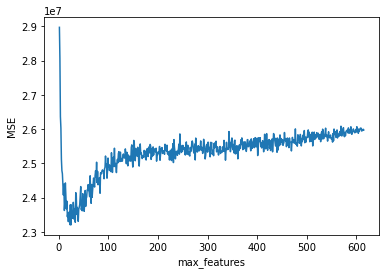

In [181]:
# Creación de lista de valores para iterar sobre diferentes valores de max_features
feature_range = range(1, len(X.columns)+1)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de max_features
mse_scores = []

# Uso de un 10-fold cross-validation para cada valor de max_features
for feature in feature_range:
    rfr = RandomForestRegressor(n_estimators=120, max_features=feature, random_state=1, n_jobs=-1)
    rfr.fit(X_train, y_train)
    y_pred = rfr.predict(X_test)
    mse_scores.append(mean_squared_error(y_test, y_pred))

# Gráfica del desempeño del modelo vs la cantidad de max_features
plt.plot(feature_range, mse_scores)
plt.xlabel('max_features')
plt.ylabel('MSE')

# Seleccionar el mejor valor de max_features
best_max_features = feature_range[np.argmin(mse_scores)]
print("El mejor valor de max_features es:", best_max_features)

rfr = RandomForestRegressor(n_estimators=120, max_features=best_max_features, random_state=1, n_jobs=-1)
rfr.fit(X_train, y_train)
# Realizar predicciones en el conjunto de prueba
y_pred = rfr.predict(X_test)
# Evaluar el rendimiento del modelo utilizando la métrica MSE
mse_m3 = mean_squared_error(y_test, y_pred)
#r2_m3 = r2_score(y_test, y_pred)
print("MSE en conjunto de prueba con mejor valor de max_features: ", mse_m3)
#print("r2 en conjunto de prueba con mejor valor de max_features: ", r2_m3)

El mejor valor de max_depth es: 187
MSE en conjunto de prueba con mejor valor de max_depth:  23965433.599835645
r2 en conjunto de prueba con mejor valor de max_depth:  0.7933051359423459


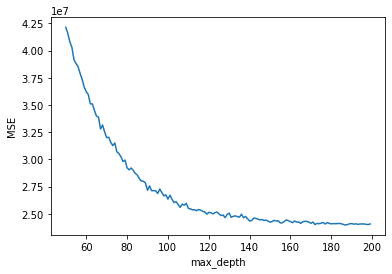

In [186]:
#max depth

# Creación de lista de valores para iterar sobre diferentes valores de max_depth
#depth_range = np.arange(1, 20)
depth_range = np.arange(50, 200)
# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de max_depth
mse_scores = []

# Uso de un 10-fold cross-validation para cada valor de max_depth
for depth in depth_range:
    rfr = RandomForestRegressor(n_estimators=120, max_features=9, max_depth = depth,random_state=1, n_jobs=-1)
    rfr.fit(X_train, y_train)
    y_pred = rfr.predict(X_test)
    mse_scores.append(mean_squared_error(y_test, y_pred))


# Gráfica del desempeño del modelo vs la cantidad de max_depth
plt.plot(depth_range, mse_scores)
plt.xlabel('max_depth')
plt.ylabel('MSE')

# Seleccionar el mejor valor de max_depth
best_max_depth = depth_range[np.argmin(mse_scores)]
print("El mejor valor de max_depth es:", best_max_depth)

rfr = RandomForestRegressor(n_estimators=120, max_features=9, max_depth= best_max_depth , random_state=1, n_jobs=-1)
rfr.fit(X_train, y_train)
# Realizar predicciones en el conjunto de prueba
y_pred = rfr.predict(X_test)
# Evaluar el rendimiento del modelo utilizando la métrica MSE
mse_m4 = mean_squared_error(y_test, y_pred)
r2_m4 = r2_score(y_test, y_pred)
print("MSE en conjunto de prueba con mejor valor de max_depth: ", mse_m4)
print("r2 en conjunto de prueba con mejor valor de max_depth: ", r2_m4)

## Entrenamiento del modelo

### Con datos de entrenamiento y validación

In [218]:
#MEJORES MODELOS

#MODELO XGBOOST

#LEARNING RATE 0.8  GAMA 0.1 COLSAMPLE 0.95
clf = XGBRegressor(learning_rate=0.8, gamma = 0.1, colsample_bytree = 0.95)
clf = XGBRegressor()
print(clf)
# Entrenamiento (fit) y desempeño del modelo XGBoost
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(f"El MSE del modelo es: {mean_squared_error(y_test, y_pred)}")
print(f"El R2 del modelo es: {r2_score(y_test, y_pred)}")

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)
El MSE del modelo es: 18229972.188478056
El R2 del modelo es: 0.8415464068147332


In [219]:
#RANDOM N ESTOMATORS 290, MAX FEATURES 24, MAX DEPTH 187

#Se entrena el modelo random forest
clfRF = RandomForestRegressor(n_estimators=290, max_features=24,max_depth= 187, random_state=1, n_jobs=-1)
#rfr = RandomForestRegressor(n_estimators=120, max_features=best_max_features, random_state=1, n_jobs=-1)
clfRF.fit(X_train, y_train)
#Luego se hacen predicciones sobre la muestra
prediccionRF=clfRF.predict(X_test)
mse = mean_squared_error(y_test, prediccionRF)
print(f"El MSE del modelo es: {mse}")
#print(f"El R2 del modelo es: {r2_score(y_test, prediccionRF)}")


El MSE del modelo es: 14725676.2581387


In [221]:
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error

# Creamos el ensamblaje de modelos
ensemble = VotingRegressor([('xgb', clf), ('rf', clfRF)])

# Ajustamos el ensamblaje a los datos de entrenamiento
ensemble.fit(X_train, y_train)

# Hacemos la predicción con el ensamblaje ajustado
y_pred = ensemble.predict(X_test)

# Calculamos el MSE del ensamblaje resultante
mse = mean_squared_error(y_test, y_pred)
mse

14506824.640715629

### Con solo datos de entrenamiento

In [90]:

#LEARNING RATE 0.8  GAMA 0.1 COLSAMPLE 0.95
clf = XGBRegressor(learning_rate=0.8, gamma = 0.1, colsample_bytree = 0.95)
clf = XGBRegressor()
print(clf)
# Entrenamiento (fit) y desempeño del modelo XGBoost
clf.fit(X, y)
y_pred = clf.predict(dataTesting)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)


In [91]:
from sklearn.ensemble import RandomForestRegressor
#Se entrena el modelo random forest
clfRF = RandomForestRegressor(n_estimators=290, max_features=24,max_depth= 187, random_state=1, n_jobs=-1)
clfRF.fit(X, y)
#Luego se hacen predicciones sobre la muestra
prediccionRF=clfRF.predict(dataTesting)


In [92]:
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error

#Creamos el ensamblaje de modelos
ensemble = VotingRegressor([('xgb', clf), ('rf', clfRF)])

# Ajustamos el ensamblaje a los datos de entrenamiento
ensemble.fit(X, y)

# Hacemos la predicción con el ensamblaje ajustado
y_pred2 = ensemble.predict(dataTesting)


### Descarga predicciones

In [32]:
y_pred2 = pd.DataFrame(y_pred2)

In [33]:
y_pred2.to_csv('test_submission.csv', index_label='ID')
y_pred2.head()

,0
0,22193.105721
1,35275.711028
2,21919.952509
3,9071.534370
4,29585.441741


## Exportacion modelo entrenado

In [93]:
import joblib
joblib.dump(ensemble,filename='model.pkl')

['model.pkl']